In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import tensorflow as tf
from tensorflow import data as tf_data

def read_image(image_path, is_mask=False):
    image = tf.io.read_file(image_path)
    if is_mask:
        mask = tf.image.decode_png(image, channels=3)
        mask = tf.image.resize(mask, [512, 512], method='nearest')
        background_color = tf.constant([0, 0, 0], dtype=tf.uint8)
        plant_color = tf.constant([0, 255, 0], dtype=tf.uint8)
        weed_color = tf.constant([255, 0, 0], dtype=tf.uint8)
        background_mask = tf.reduce_all(tf.equal(mask, background_color), axis=-1)
        plant_mask = tf.reduce_all(tf.equal(mask, plant_color), axis=-1)
        weed_mask = tf.reduce_all(tf.equal(mask, weed_color), axis=-1)
        mask = tf.cast(weed_mask, dtype=tf.uint8) * 2 + tf.cast(plant_mask, dtype=tf.uint8)
        mask = tf.expand_dims(mask, axis=-1)

        return mask
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [512, 512])
        return image

def process_path(image_path, label_path):
    img = read_image(image_path)
    mask = read_image(label_path, is_mask=True)
    return img, mask

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(4)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def prepare_datasets(image_dir, label_dir, split=0.8):
    image_paths = tf.data.Dataset.list_files(os.path.join(image_dir, '*.png'), shuffle=False)
    label_paths = tf.data.Dataset.list_files(os.path.join(label_dir, '*.png'), shuffle=False)

    paired_paths = tf.data.Dataset.zip((image_paths, label_paths))

    paired_paths = paired_paths.shuffle(buffer_size=1000)
    image_count = paired_paths.cardinality().numpy()

    train_size = int(split * image_count)
    train_ds = paired_paths.take(train_size)
    val_ds = paired_paths.skip(train_size)

    train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = configure_for_performance(train_ds)
    val_ds = configure_for_performance(val_ds)

    return train_ds, val_ds

IMAGE_DIR = '/content/drive/My Drive/Project/Datasets/CWFID/AugmentedImages'
LABEL_DIR = '/content/drive/My Drive/Project/Datasets/CWFID/AugmentedAnnotations'


train_dataset, val_dataset = prepare_datasets(IMAGE_DIR, LABEL_DIR)

print("Training and Validation datasets are ready!")


Training and Validation datasets are ready!


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal()
    )(block_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, num_filters=256, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(size=(
        dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation='bilinear'
    )(x)

    out_1 = convolution_block(dspp_input, num_filters=256, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, num_filters=256, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, num_filters=256, kernel_size=1)
    return output

def DeepLabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )

    low_level_features = resnet50.get_layer("conv2_block3_2_relu").output
    encoder_output = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(encoder_output)

    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = layers.Concatenate()([x, low_level_features])

    x = convolution_block(x, num_filters=256)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    return keras.Model(inputs=model_input, outputs=model_output)

1/1 [==============================] - 0s 30ms/step
Model model: Precision=0.6299588969904427, Recall=0.3779286225800592, F1=0.3959944744721077, mIoU=0.35299408435821533, Accuracy=0.936129093170166, Loss=0.9920695424079895
1/1 [==============================] - 0s 31ms/step
Model model: Precision=0.9529986426312252, Recall=0.9561280055532461, F1=0.9543994316927659, mIoU=0.9147412776947021, Accuracy=0.9638619422912598, Loss=0.03887980058789253
1/1 [==============================] - 0s 30ms/step
Model model: Precision=0.5923051609186576, Recall=0.5367007173930551, F1=0.5500633659973373, mIoU=0.4679555594921112, Accuracy=0.9576953649520874, Loss=0.693799614906311
1/1 [==============================] - 0s 30ms/step
Model model: Precision=0.5458644739155897, Recall=0.6086358422284688, F1=0.4552238047726129, mIoU=0.3897959887981415, Accuracy=0.947070837020874, Loss=1.0728987455368042
1/1 [==============================] - 0s 31ms/step
Model model_1: Precision=0.38939327876110963, Recall=0.50

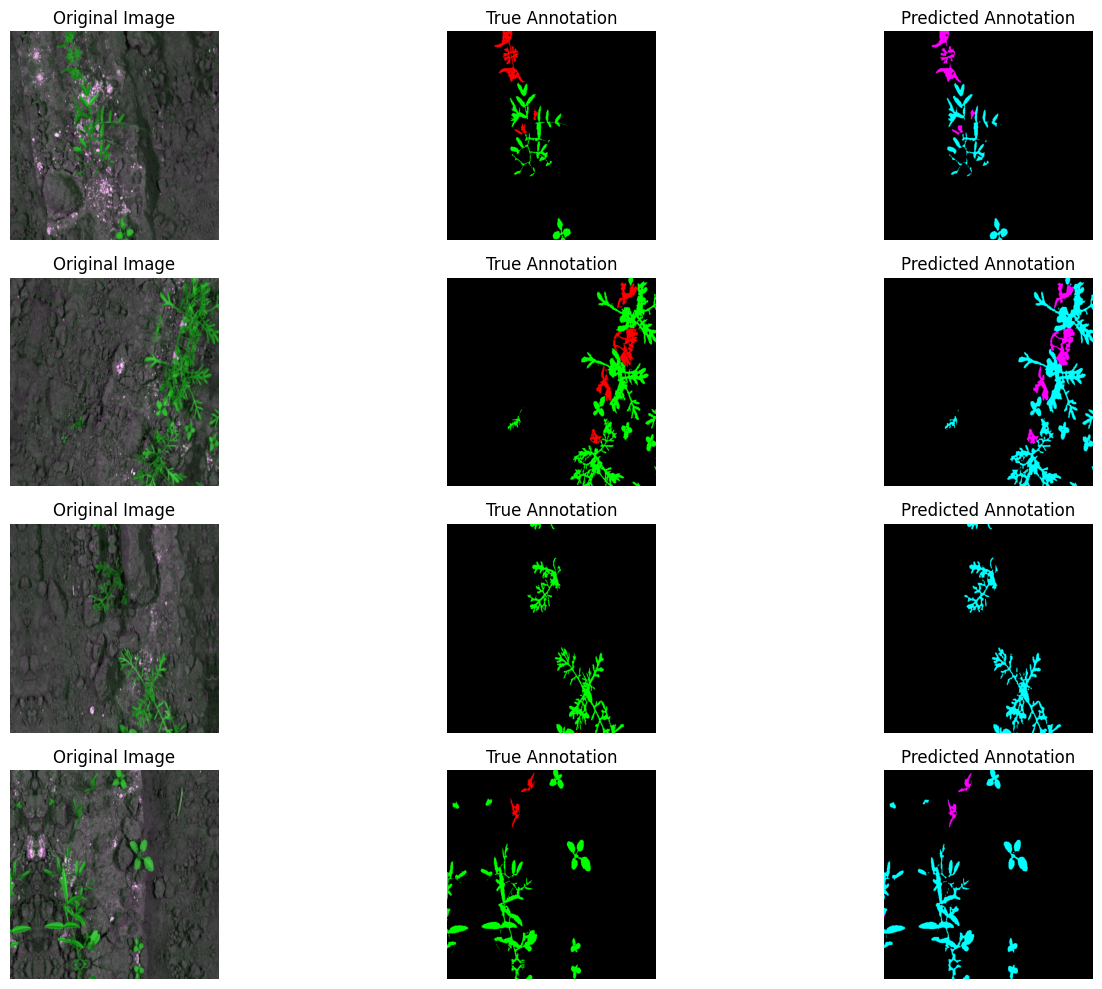

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.metrics import MeanIoU, CategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def indices_to_rgb_image(lbl, num_classes=3, mapping_type='true'):
    if mapping_type == 'true_rgb':
        label_to_color = {
            0: [0, 0, 0],      # Background - Black
            1: [0, 255, 0],    # Plant - Green
            2: [255, 0, 0]     # Weed - Red
        }
    elif mapping_type == 'pred_rgb':
        label_to_color = {
            0: [0, 0, 0],      # Background - Black
            1: [0, 255, 255],  # Plant - Cyan
            2: [255, 0, 255]   # Weed - Magenta
        }
    rgb_image = np.zeros((*lbl.shape, 3), dtype=np.uint8)
    for i in range(num_classes):
        rgb_image[lbl == i] = label_to_color[i]
    return rgb_image

def plot_comparison(images, true_masks, pred_masks):
    plt.figure(figsize=(15, 10))
    count = len(images)
    for i in range(count):
        plt.subplot(count, 3, 3*i + 1)
        plt.imshow(tf.squeeze(images[i]).numpy().astype("uint8"))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(count, 3, 3*i + 2)
        true_rgb = indices_to_rgb_image(tf.squeeze(true_masks[i]), 3, 'true_rgb')
        plt.imshow(true_rgb)
        plt.title('True Annotation')
        plt.axis('off')

        plt.subplot(count, 3, 3*i + 3)
        pred_rgb = indices_to_rgb_image(tf.squeeze(pred_masks[i]), 3, 'pred_rgb')
        plt.imshow(pred_rgb)
        plt.title('Predicted Annotation')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

model_paths = [
    '/content/drive/My Drive/Project/Models/DeepLabPotato',
    '/content/drive/My Drive/Project/Models/DeepLabCWFID',
    '/content/drive/My Drive/Project/Models/DeepLabSunflower',
    '/content/drive/My Drive/Project/Models/DeepLabSB',
    '/content/drive/My Drive/Project/Models/DeepLabCnW'
]
models = [tf.keras.models.load_model(path) for path in model_paths]

def evaluate_models(models, dataset):
    if not models:
        print("No models to evaluate.")
        return None, {}

    best_score = 0
    best_model = None
    best_metrics = {}
    accuracy_metric = CategoricalAccuracy()
    loss_fn = SparseCategoricalCrossentropy()

    for model in models:
        miou_metric = MeanIoU(num_classes=3)
        precision_lst, recall_lst, f1_lst, accuracy_lst, loss_lst = [], [], [], [], []

        for img_batch, mask_batch in dataset:
            predictions = model.predict(img_batch)
            pred_labels = tf.argmax(predictions, axis=-1)


            mask_batch = tf.cast(mask_batch, dtype=tf.int32)
            mask_batch_flat = tf.reshape(mask_batch, [-1])
            miou_metric.update_state(mask_batch, pred_labels)
            pred_labels_flat = tf.reshape(pred_labels, [-1])
            precision_lst.append(precision_score(mask_batch_flat.numpy(), pred_labels_flat.numpy(), average='macro', zero_division=0))
            recall_lst.append(recall_score(mask_batch_flat.numpy(), pred_labels_flat.numpy(), average='macro', zero_division=0))
            f1_lst.append(f1_score(mask_batch_flat.numpy(), pred_labels_flat.numpy(), average='macro', zero_division=0))
            accuracy_metric.update_state(tf.one_hot(mask_batch_flat, 3), tf.one_hot(pred_labels_flat, 3))
            loss_lst.append(loss_fn(mask_batch_flat, predictions).numpy())

        accuracy = accuracy_metric.result().numpy()
        miou = miou_metric.result().numpy()
        precision, recall, f1 = np.mean(precision_lst), np.mean(recall_lst), np.mean(f1_lst)
        avg_loss = np.mean(loss_lst)

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_metrics = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'miou': miou,
                'accuracy': accuracy,
                'loss': avg_loss
            }
        print(f"Model {model.name}: Precision={precision}, Recall={recall}, F1={f1}, mIoU={miou}, Accuracy={accuracy}, Loss={avg_loss}")

    if not best_model:
        print("No best model found. Check model performance or dataset.")
        return None, {}

    return best_model, best_metrics


best_model, best_metrics = evaluate_models(models, val_dataset)
if best_model:
    print("\nModel Metrics:")
    print(f"Precision: {best_metrics['precision']}")
    print(f"Recall: {best_metrics['recall']}")
    print(f"F1 Score: {best_metrics['f1']}")
    print(f"Mean IoU: {best_metrics['miou']}")
    print(f"Accuracy: {best_metrics['accuracy']}")
    print(f"Loss: {best_metrics['loss']}")

    for img_batch, mask_batch in val_dataset.take(1):
        predictions = best_model.predict(img_batch)
        pred_labels = tf.argmax(predictions, axis=-1)
        plot_comparison(img_batch, mask_batch, pred_labels)
else:
    print("No models evaluated successfully.")
